In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [ ]:
import art
from dotenv import load_dotenv
import random
from openpipe.client import OpenPipe

load_dotenv()

op_client = OpenPipe()
print("OpenPipe client initialized")

random.seed(42)


api = art.LocalAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="tic-tac-toe-002", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)

$ vllm serve /root/sky_workdir/examples/.art/models/tic-tac-toe-002/0001 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=1 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=tic-tac-toe-002 --port=8000 --api-key=default


Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.36it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.03it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.01it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.22it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.16it/s]

INFO:     Started server process [33540]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO:     127.0.0.1:38822 - "POST /v1/chat/completions HTTP/1.1" 200 OK


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


"train/completion_tokens" not found in run history


val:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?it/s]

/root/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/root/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


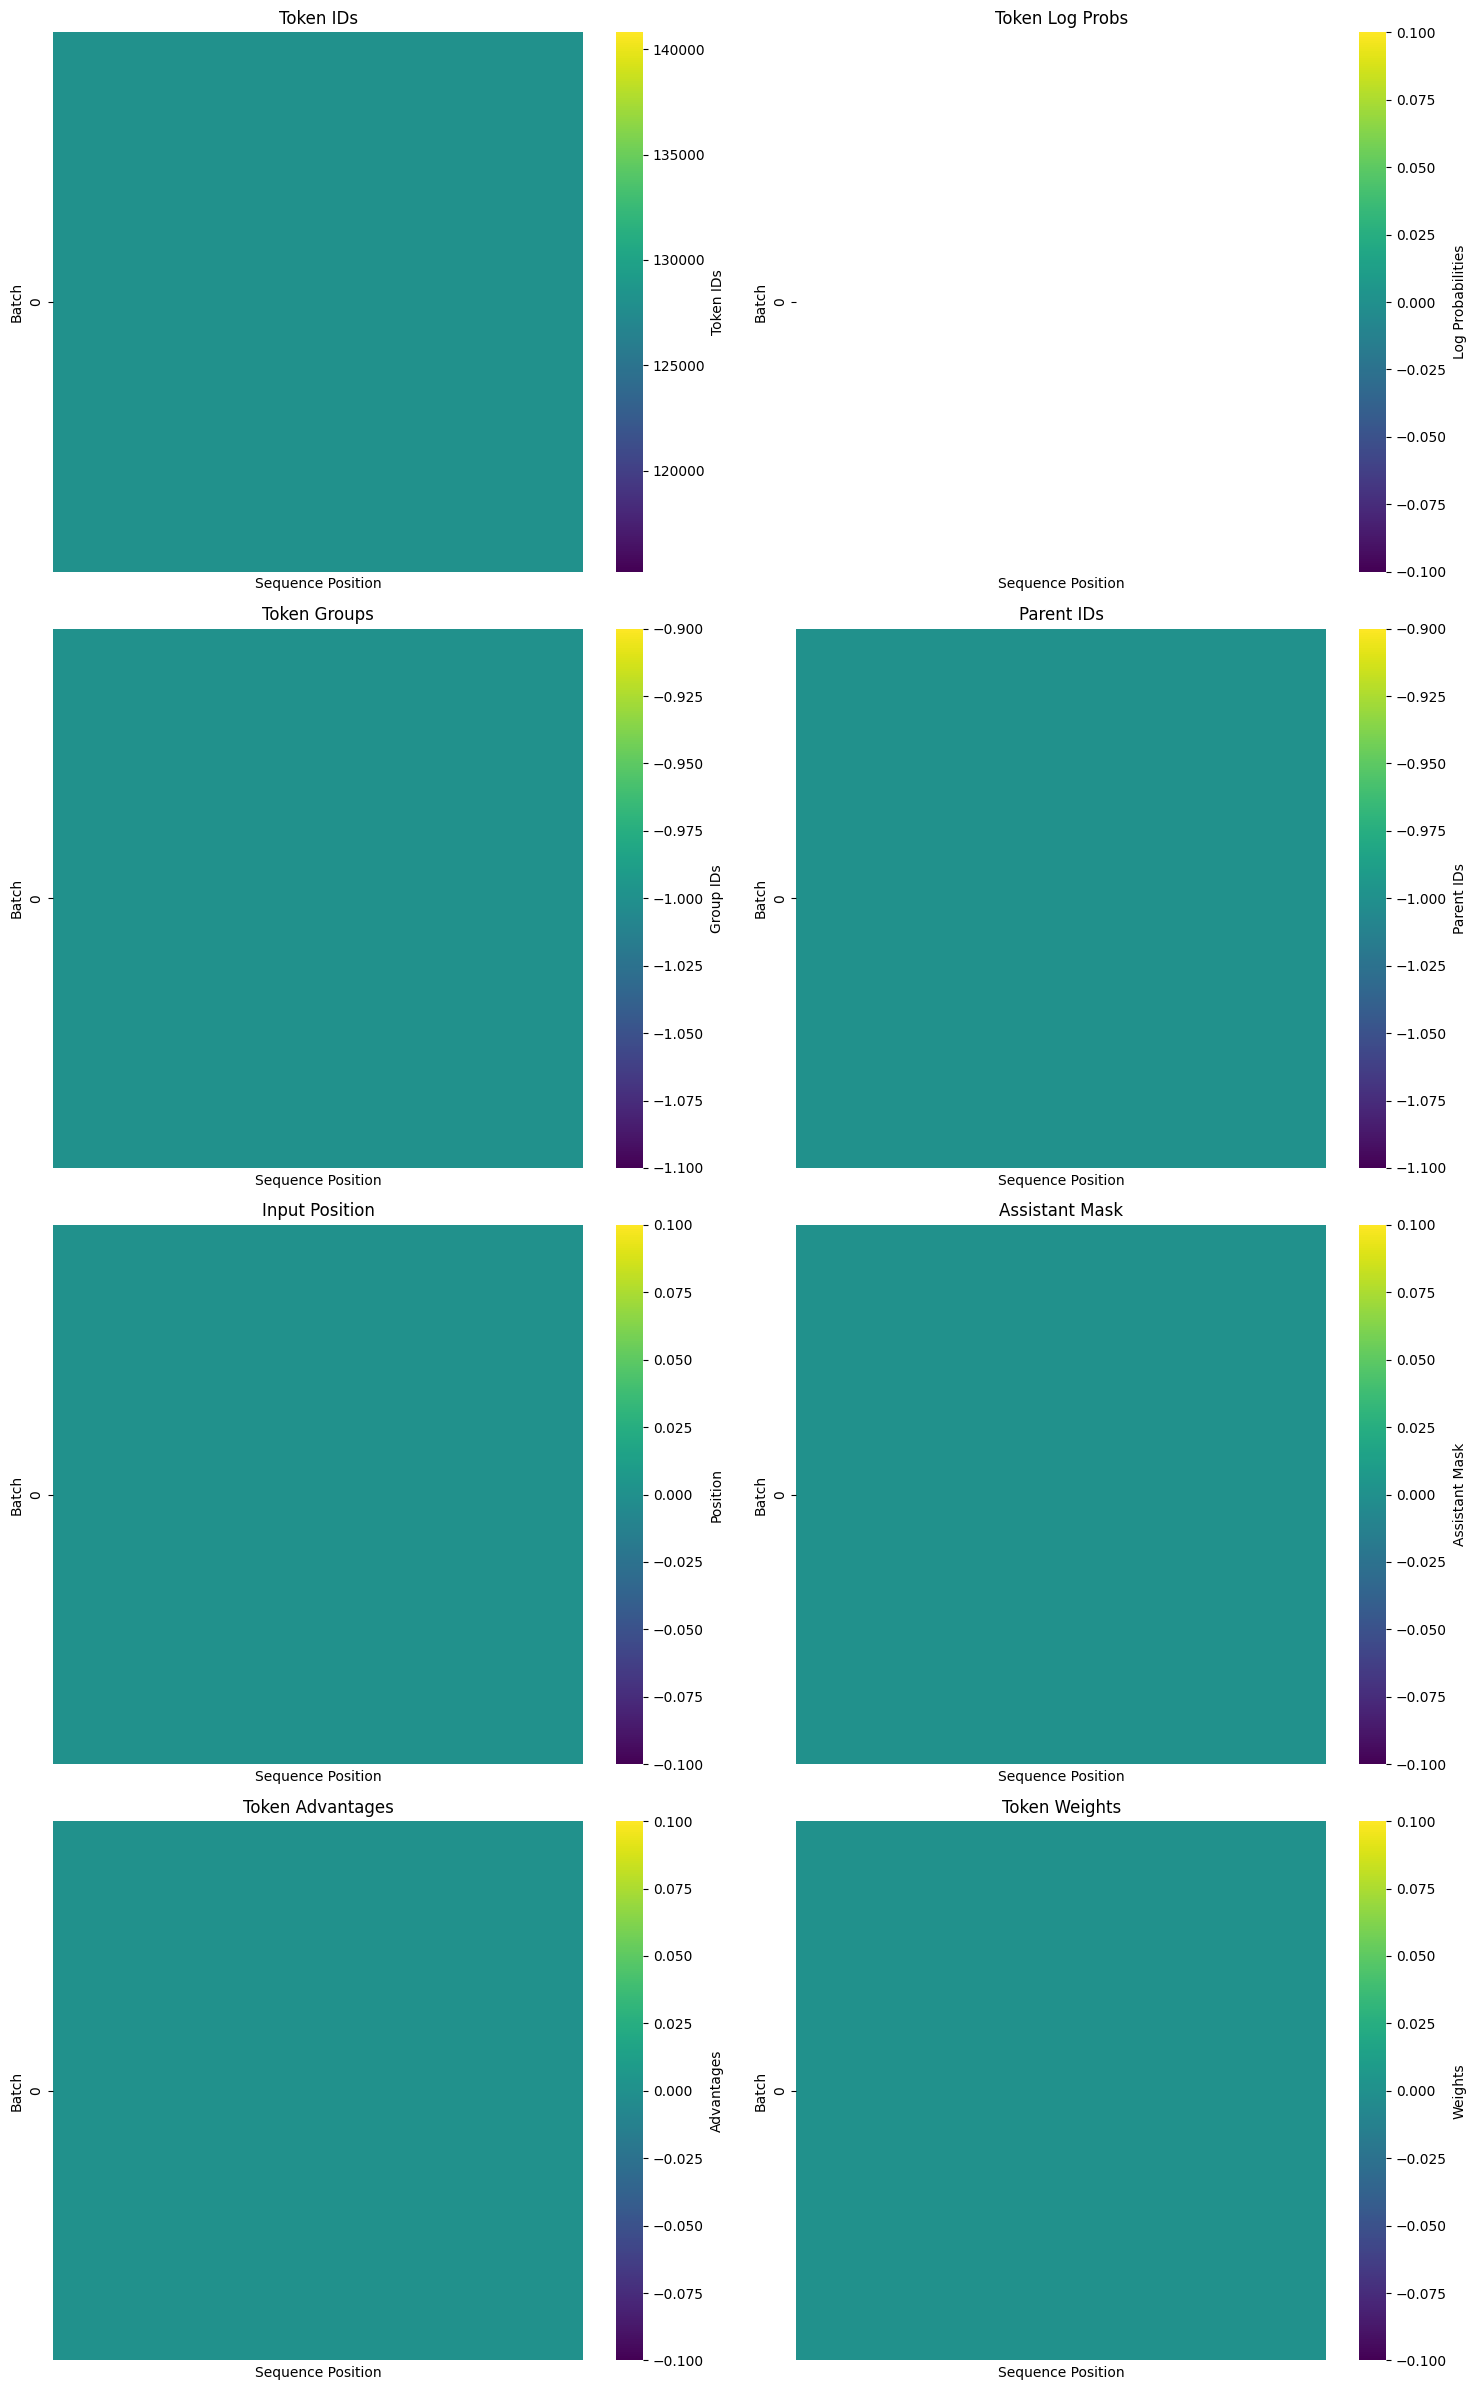

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/tic-tac-toe-002/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 256
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/tic-tac-toe-002/0001
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/tic-tac-toe-002
  recipe_checkpoint: null
compile: true
custom_shard

Writing logs to .art/models/tic-tac-toe-002/logs/log_1743170559.txt


AssertionError: No epoch directory found in output directory ./.art/models/tic-tac-toe-002

In [4]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
from typing import TypedDict
from openpipe.client import OpenPipe
import time
from typing import Literal
from pydantic import BaseModel

load_dotenv()


class TicTacToeGame(TypedDict):
    board: list[list[str]]
    agent_symbol: Literal["x", "o"]
    opponent_symbol: Literal["x", "o"]


def generate_game(board_length: int = 3) -> TicTacToeGame:
    board = [["_" for _ in range(board_length)] for _ in range(board_length)]
    agent_symbol = random.choice(["x", "o"])
    opponent_symbol = "x" if agent_symbol == "o" else "o"
    return {
        "board": board,
        "agent_symbol": agent_symbol,
        "opponent_symbol": opponent_symbol,
    }


def render_board(game: TicTacToeGame) -> str:
    board = game["board"]
    board_length = len(board)
    # print something like this:
    #    1   2   3
    # A  _ | x | x
    # B  o | _ | _
    # C  _ | o | _
    # where _ is an empty cell

    board_str = "   " + "   ".join([str(i + 1) for i in range(board_length)]) + "\n"
    for i in range(board_length):
        board_str += f"{chr(65 + i)}  {board[i][0]} | {board[i][1]} | {board[i][2]}\n"
    return board_str


def get_opponent_move(game: TicTacToeGame) -> tuple[int, int]:
    # get a random empty cell
    empty_cells = [
        (i, j) for i in range(3) for j in range(3) if game["board"][i][j] == "_"
    ]
    return random.choice(empty_cells)


class AgentMove(BaseModel):
    reason: str
    square: str


def apply_agent_move(game: TicTacToeGame, move: str) -> None:
    board_length = len(game["board"])
    json_move = json.loads(move)
    square = json_move["square"]

    try:
        row_index = ord(square[0]) - 65
        col_index = int(square[1]) - 1
    except Exception as e:
        print(e)
        raise ValueError("Unable to parse square")

    if (
        row_index < 0
        or row_index >= board_length
        or col_index < 0
        or col_index >= board_length
    ):
        raise ValueError(
            f"Invalid move, row or column out of bounds: {row_index}, {col_index}"
        )

    # check if the move is valid
    if game["board"][row_index][col_index] != "_":
        raise ValueError("Square already occupied")

    game["board"][row_index][col_index] = game["agent_symbol"]


def check_winner(board: list[list[str]]) -> Literal["x", "o", "draw", None]:
    board_length = len(board)
    # check rows
    for row in board:
        if row.count(row[0]) == board_length and row[0] != "_":
            return row[0]
    # check columns
    for col in range(board_length):
        if [board[row][col] for row in range(board_length)].count(
            board[0][col]
        ) == board_length and board[0][col] != "_":
            return board[0][col]

    # top right to bottom left
    upward_diagonal = [board[i][board_length - i - 1] for i in range(board_length)]
    if (
        upward_diagonal.count(upward_diagonal[0]) == board_length
        and upward_diagonal[0] != "_"
    ):
        return upward_diagonal[0]

    # top left to bottom right
    downward_diagonal = [board[i][i] for i in range(board_length)]
    if (
        downward_diagonal.count(downward_diagonal[0]) == board_length
        and downward_diagonal[0] != "_"
    ):
        return downward_diagonal[0]

    # check for draw
    if all(cell != "_" for row in board for cell in row):
        return "draw"
    return None


def get_trajectory_messages(trajectory: art.Trajectory) -> art.Messages:
    messages: art.Messages = []
    for item in trajectory.messages_and_choices:

        # if item is not a dict, convert it to a dict
        if not isinstance(item, dict):
            item = item.to_dict()

        # check if item is a choice
        if "message" in item:
            messages.append(
                {"role": "assistant", "content": item["message"]["content"]}
            )
        else:
            # otherwise it's a message
            messages.append(item)
    return messages


failing_trajectory = None


async def rollout(
    client: openai.AsyncOpenAI, iteration: int, is_validation: bool
) -> art.Trajectory:

    game = generate_game()

    trajectory = art.Trajectory(
        messages_and_choices=[
            {
                "role": "system",
                "content": f"You are a tic-tac-toe player. You are playing against an opponent. Always choose the move most likely to lead to an eventual win. Return the move in the format 'A1', 'B2', 'C3', etc. You are the {game['agent_symbol']} symbol.",
            }
        ],
        reward=0,
        metrics={"test": 5},
    )

    if game["agent_symbol"] == "o":
        starting_opponent_move = get_opponent_move(game)
        game["board"][starting_opponent_move[0]][starting_opponent_move[1]] = game[
            "opponent_symbol"
        ]

    while check_winner(game["board"]) is None:

        trajectory.messages_and_choices.append(
            {"role": "user", "content": render_board(game)}
        )

        requested_at = int(time.time() * 1000)
        messages = get_trajectory_messages(trajectory)

        async def get_completion():
            return await client.beta.chat.completions.parse(
                logprobs=True,
                messages=messages,
                model=model.name,
                response_format=AgentMove,
            )

        try:
            chat_completion = await get_completion()
        except openai.LengthFinishReasonError as e:
            print(e)
            chat_completion = await get_completion()
        except Exception as e:
            print("caught exception generating chat completion")
            print(e)
            global failing_trajectory
            failing_trajectory = trajectory
            raise e

        op_client.report(
            requested_at=requested_at,
            received_at=int(time.time() * 1000),
            req_payload={
                "model": model.name,
                "messages": messages,
                "metadata": {
                    "notebook-id": "tic-tac-toe",
                    "iteration": str(iteration),
                    "validation": str(is_validation),
                    "move_number": str(len(trajectory.messages_and_choices) - 1),
                },
            },
            resp_payload=chat_completion,
            status_code=200,
        )

        choice = chat_completion.choices[0]
        content = choice.message.content
        assert isinstance(content, str)
        trajectory.messages_and_choices.append(choice)

        try:
            apply_agent_move(game, content)
        except ValueError as e:
            trajectory.reward = 0
            break

        if check_winner(game["board"]) is not None:
            break

        opponent_move = get_opponent_move(game)
        game["board"][opponent_move[0]][opponent_move[1]] = game["opponent_symbol"]

    winner = check_winner(game["board"])

    if winner == game["agent_symbol"]:
        trajectory.reward = 1
    elif winner == game["opponent_symbol"]:
        trajectory.reward = 0
    elif winner == "draw":
        trajectory.reward = 0.5

    return trajectory


stride = 32
for i in range(await model.get_iteration(), 10):
    async with model.openai_client(
        estimated_completion_tokens=350, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_trajectories(
                (
                    (rollout(openai_client, i, is_validation=True) for _ in range(2))
                    for _ in range(1)
                ),
                pbar_desc="val",
                stream_chat_completions=8,
                return_exceptions=False,
            ),
            art.gather_trajectories(
                (
                    (rollout(openai_client, i, is_validation=False) for _ in range(50))
                    for _ in range(1)
                ),
                pbar_desc="train",
                return_exceptions=False,
            ),
        )
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )